### Do NOT click RUN ALL... or else you will spend 20 minutes redefining the embeddings

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
from transformers import TFBertModel, BertTokenizer,BertConfig
import re
import pickle
import sys
import gc
import os
import pdfplumber
import shutil
import glob
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE
import math
import random
import sklearn

# np.random.seed(42)
# tf.random.set_seed(42)
# os.environ['PYTHONHASHSEED']=str(42)
tf.keras.utils.set_random_seed(42)


# Defining

Code for ProtBERT and BFD

In [2]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-02-02 21:25:41.484826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-02 21:25:41.484947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorc

In [3]:
def get_embeddings(sequence_list):
    # tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
    # embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding=True, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids)[0])
    print(np.shape(input_ids))
    average_embeddings = []
    for seq_num in range(len(embedding)):

        seq_len = (attention_mask[seq_num] == 1).sum()
        
        # seq_len = (len(attention_mask[seq_num]))
        residues = embedding[seq_num][1:seq_len-1]
        average = np.mean(residues, axis=0)
        average_embeddings.append(average)
    
    del residues
    del average
    del ids
    del sequence_list
    del embedding
    del input_ids
    del attention_mask
    gc.collect()

    return np.asarray(average_embeddings)

In [4]:
sequences_Example = ["A E T C Z A O","S K T Z P"] # REMEMBER SPACING

In [5]:
average_embeddings = get_embeddings(sequences_Example)

(2, 9)


In [6]:
tf.__version__

'2.10.0'

# Data Formatting

In [7]:
# Read PDF of 62 Sequences
pdf_sequences = []

with pdfplumber.open('../Data/Influenza/DataSheet_1.pdf') as pdf:
    first_page = pdf.pages[0]
    text = first_page.extract_text()
pdf_sequences = text.split("\n")
pdf_sequences = pdf_sequences[3:]
for i in range(len(pdf_sequences)):
    pdf_sequences[i] = pdf_sequences[i].split(" ")[-2]
print(len(pdf_sequences))

62


In [8]:
# Read GenBank and Uniprot

dummy = []
head = []
flag = False
with open("../Data/Influenza/genbank.txt") as myfile:
    for i in myfile:
        dummy.append(i)
    for i in dummy:
        if flag == True:
            flag = False
            continue
        if i.find("light") != -1 or i.find("Light") != -1:
            flag = True
            continue
        if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
            if (len(i) <= 138) & (len(i) >= 100):
                if i not in head:
                    head.append(i)
    np.random.shuffle(head)
print(head[:5], len(head))
influenza_sequences = head

dummy = []
head = []
flag = False
with open("../Data/Influenza/uniprot_sequences.txt") as myfile:
    for i in myfile:
        dummy.append(i)
    for i in dummy:
        if flag == True:
            flag = False
            continue
        if i.find("light") != -1 or i.find("Light") != -1:
            flag = True
            continue
        if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
            if (len(i) <= 138) & (len(i) >= 100):
                if i not in head:
                    head.append(i)
    np.random.shuffle(head)
print(head[:5], len(head))

influenza_sequences = np.concatenate((influenza_sequences, head))

textual_sequences = list(dict.fromkeys(influenza_sequences))

['EVQLVESGGGLVKPGGSLRLSCASSGFNFSNAWVKWVRQAPGKGLEWVGRIKSETDGGTTDYAAPVKGRFTISRDNSRNTLYLQLNSLRTEDTGMYYCTTSRKSYYYLMDVWGQGTAVTVSA\n', 'EVQLVESGGGLVHPGMSLRLSCAASGFTFSYHWMSWVRQAPGKGLEWVANIKEDGSEKNYVDSVKGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCTRATWESSGWTPFDYWGQGTLVTVSS\n', 'QVQLVESGGGVVQPGRSLRLSCEASGFTFSRYGVHWVRQAPGKGLEWVAVIWDASFTNYTKSVRGRFTISRDDSKNTLYLQMNSLRAEDTAVYYCARDPPYRTGHLDYWGQGTLVIVSS\n', 'QLHLQESGPGLVKPSETLSLTCSVSGGSISSRYYYWGWIRQPPGKGLDWIGSISYTGTTFFKSSLKSRVTMTADTSKDQFSLKLTSVTAADTALYFCARYNVGDSGAYYGVFLIS\n', 'QVQLVQSGAEVKKPGSSVKVSCKASGGIFRNYAISWVRQAPGQGLEWMGGIAAIFGTTNYAQKFQGRVTITADESTTTAYMELSSLESEDTAVYYCARGPNYVPNSYFDFWGQGTLVAVSS\n'] 983
['QVQLVQSGGGVVQPGRSLRLSCVASGFTFSTYAMHWVRQAPGRGLEWVAVISYDGNYKYYADSVKGRFSISRDNSNNTLHLEMNTLRTEDTALYYCAKDSQLRSLLYFEWLSQGYFDPWGQGTLVTVSS\n', 'QVQLVESGGGVVQPGRSLRLSCAASGFTFSTYAMHWVRQAPGKGLEWVAVISYDANYKYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCAKDSQLRSLLYFEWLSQGYFDYWGQGTLVTVSS\n', 'QVQLVQSGGGVVQPGRSLRLSCAASGFTFSTYGMHWVRQAPGKGLEWVAVISYDGNYKYYADSVKGRFTISRDNSKNTLYLEMNSLRTEDTALY

In [9]:
# Read JSAV
df = pd.read_csv("../Data/Influenza/JSAV_Export.csv", skiprows=1)
df.drop(df.columns[[0, 1, 2, 3, 4, 5]], axis=1, inplace=True)
df.drop(["H52A", "H52B", "H52C", "H82A", "H82B", "H82C", "H100A", "H100B", "H100C", "H100D", "H100E", "H100F", "H100G", "H100H", "H100I", "H100J", "H100K", "H100L", "H100M", "H100N", "H100O", "H100P"], axis=1, inplace=True)
array = df.to_string(header=False, index=False, index_names=False).split('\n')
jsav_sequences = []
for i in array:
    if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
        i = i.replace(" ", "")
        print(i)
        jsav_sequences.append(i)

EVQLVESGGGLVTPGGSLRLSCAASGFTFNTYSMNWVRQAPGKGLEWVSSISSSDYIYYADSVKGRFTISRDNAKNSVYLQMRDEDTAVYYCARDPGGMPLYWGQGTLVTVSS
QVQLQQSGPELVKPGASVKISCKASAYAFSNSWMNWVKQRPGQGLEWIGRIYGDGDTRYNGKFKGKATLTADNSSTTAYMQLTSVDSAVYFCASSGNYHPDYWGQGTSVTVSS
EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYIHWVKQRPEQGLEWIGRIDAIGNTKYDPKFQGKATITADTSSNTAYLQLTSEDTAVYYCSRGITPYYDYWGQGTSVTVSS
QVQLEESGGGLVQPGNSLKLSCAASGFTFSDYTMAWVRQSPKKGLEWVTTILDGSSTYYRDSVKGRFTISRDNAKSTLYLQMRSEDTATYYCATPFTDYDDYWGQGTPVTVSS
EVQLLESGGGLVQPGGSLRLSCATSGFSFSNYWMTWVRQAPGKGLEWVANIKEGSEEYYVDSVKGRFTISRDNAKNSLYLQMRAEDTAVYYCARQGSFADDVWGQGTTVTVSS
EVQLVESGGGLVQPGGSLRLSCVDSGFTFRSYWMTWVRQAPGKGLEWVANINDGSEKYYVDSVKGRFTISRDNAKNSLYLQMRAEDTAVYYCARQGSFGDDVWGQGTTVTVSS
QVQLVESGGGVVQPGRSLRLSCAASGFTFSEYGMHWVRQPPGKGLEWVALIYGGTDDHYADSVKGRFTISRDNSKNTLFLQMRVEDTAVYFCARDEWAVHDVWGRGTTVTVSS
EVQLVESGGDLVKPGGSLRLSCAASGFSFSYASMTWVRQAPGKGLEWVGRIKWGGTTDYAAPVRGRFTISRDDSKNTLFLQMNTEDTAVYFCVTAATHDYNYWGRGTLVTVSS
QVQLVQSGAEVKKPGSSVKVSCKTSGVTFSSFSVSWVRQAPGQGLEWMGRIIILGMTNYAQKFQGRVTITADRSTSVASMEFKSEDTA

In [10]:
# Read CSV
excel_sequences = []
xls = pd.ExcelFile("../Data/Influenza/2016_Cell.xlsx")
## mini function but I'm too lazy to write it as one
df1 = pd.read_excel(xls, "Subject 1", skiprows=2)
df1 = df1[["Heavy chain protein sequence"]]
df1 = df1.dropna()
temp_sequences = df1.to_numpy()
temp_sequences = [i for sub_list in temp_sequences for i in sub_list]
for i in temp_sequences:

    excel_sequences.append(i)
print(len(excel_sequences))

df1 = pd.read_excel(xls, "Subject 16")
df1 = df1[["Heavy chain protein sequence"]]
df1 = df1.dropna()
temp_sequences = df1.to_numpy()
temp_sequences = [i for sub_list in temp_sequences for i in sub_list]
for i in temp_sequences:
    excel_sequences.append(i)
print(len(excel_sequences))

df1 = pd.read_excel(xls, "Subject 31")
df1 = df1[["Heavy chain protein sequence"]]
df1 = df1.dropna()
temp_sequences = df1.to_numpy()
temp_sequences = [i for sub_list in temp_sequences for i in sub_list]
for i in temp_sequences:
    excel_sequences.append(i)
print(len(excel_sequences))

df1 = pd.read_excel(xls, "Subject 36")
df1 = df1[["Heavy chain protein sequence"]]
df1 = df1.dropna()
temp_sequences = df1.to_numpy()
temp_sequences = [i for sub_list in temp_sequences for i in sub_list]
for i in temp_sequences:
    excel_sequences.append(i)
print(len(excel_sequences))

df1 = pd.read_excel(xls, "Subject 54")
df1 = df1[["Heavy chain protein sequence"]]
df1 = df1.dropna()
temp_sequences = df1.to_numpy()
temp_sequences = [i for sub_list in temp_sequences for i in sub_list]
for i in temp_sequences:
    excel_sequences.append(i)
print(len(excel_sequences))

df1 = pd.read_excel(xls, "Subject 56")
df1 = df1[["Heavy chain protein sequence"]]
df1 = df1.dropna()
temp_sequences = df1.to_numpy()
temp_sequences = [i for sub_list in temp_sequences for i in sub_list]
for i in temp_sequences:
    excel_sequences.append(i)
print(len(excel_sequences))

df1 = pd.read_excel(xls, "Addititional sequences", skiprows=[60, 63, 66])
df1 = df1[["Sequence"]]
df1 = df1.dropna()
temp_sequences = df1.to_numpy()
temp_sequences = [i for sub_list in temp_sequences for i in sub_list]
for i in temp_sequences:
    excel_sequences.append(i)
print(len(excel_sequences))

94
329
465
478
580
645
695


/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/openpyxl/workshee

In [11]:
# Read PDB's
pdb_sequences = []
stem = "../Data/Influenza/PDB/"
# filelist = os.listdir("../Data/Influenza/PDB/")
# filelist.remove(".DS_Store")
# for i in filelist:
#     shutil.copy(stem + i, stem + i.split(".")[-2] + ".txt")

filelist = glob.glob(stem + '*.txt')
for i in filelist:
    with open(i) as myfile:
        flag = False
        for j in myfile:
            if flag == True:
                pdb_sequences.append(j)
                flag = False
            if j.find("Heavy") != -1 or j.find("heavy") != -1:
                print(j)
                flag = True
print(pdb_sequences)

>5UMN_2|Chains C, E|Antibody C05 VPGSGW mutant, heavy chain|Homo sapiens (9606)

>6PZY_2|Chains B[auth C], E[auth G], H, K[auth I]|NA-73 fragment antibody heavy chain|Homo sapiens (9606)

>3QHF_1|Chain A[auth H]|Human monoclonal antibody  del2D1, Fab Heavy Chain|Homo sapiens (9606)

>4HG4_3|Chains AA[auth J], CA[auth L], EA[auth N], GA[auth P], IA[auth R], S[auth T], U[auth V], W[auth X], Y[auth Z]|Fab 2G1 heavy chain|Homo sapiens (9606)

>5XKU_3|Chain C|HNIgGA6 heavy chain|Homo sapiens (9606)

>6CNV_5|Chain E[auth H]|CR9114 Fab heavy chain|Homo sapiens (9606)

>5CJS_2|Chains B[auth F], F[auth H]|CR9114 heavy chain|Homo sapiens (9606)

>4O5I_3|Chains M, O, Q, S, U, W|Fab F045-092 heavy chain|Homo sapiens (9606)

>6PZZ_3|Chains C[auth F], F[auth H], I, L[auth K]|NA-80 fragment antibody heavy chain|Homo sapiens (9606)

>5DUR_1|Chains A[auth B], D[auth H]|Heavy Chain of Antibody 100F4|Homo sapiens (9606)

>4KVN_2|Chain B[auth H]|Human IgG Heavy Chain|Homo sapiens (9606)

>3GBN_3|Chain C[a

In [12]:
# need mass filtering, making sure between 100 and 138

influenza_sequences = np.concatenate((pdf_sequences, textual_sequences, jsav_sequences, excel_sequences, pdb_sequences))

influenza_sequences = list(dict.fromkeys(influenza_sequences))
print(len(influenza_sequences))
influenza_sequences = [i for i in influenza_sequences if len(i) >= 100]
print(len(influenza_sequences))
influenza_sequences = [i for i in influenza_sequences if len(i) <= 138]
print(len(influenza_sequences))
influenza_sequences = [i for i in influenza_sequences if i.find("X") == -1 if i.find("-") == -1]
print(len(influenza_sequences))
np.random.shuffle(influenza_sequences)

1656
1653
1590
1541


In [13]:
# shutil.copy("../Data/influenza/heavy_seqs_aa.fasta", "../Data/influenza/heavy_seqs_aa.txt")
# OR
# Run the following too when new download
# awk '/^>/ {printf("\n%s\n",$0);next; } { printf("%s",$0);}  END {printf("\n");}' < file.fa > out.txt
# Then, delete the first empty line

In [14]:
head = []
dummy = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for influenza, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 5000:
                    break
print(head[:5], len(head))
healthy_sequences = head

In [ ]:
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(influenza_sequences, key=len)))
print(len(healthy_sequences))
print(len(influenza_sequences))
# print(influenza_sequences)

137
138
5000
1541


In [ ]:
del head
del myfile
del dummy
gc.collect()

1765

In [ ]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [2]:
if os.path.exists('influenza_binary_embeddings') == False:
    os.mkdir('influenza_binary_embeddings')

In [3]:
number_param_influenza = math.ceil(len(influenza_sequences)/3000)

for i in range(number_param_influenza):
    influenza_sequences_new = [(" ".join(s)) for s in influenza_sequences][round(len(influenza_sequences) * (1/number_param_influenza) * i):round(len(influenza_sequences) * (1/number_param_influenza) * (i+1))]
    influenza_average_embeddings = get_embeddings(influenza_sequences_new)

    with open("influenza_binary_embeddings/influenza_" + str(i) + ".pkl", "wb") as f:
        pickle.dump(influenza_average_embeddings, f)

    del influenza_sequences_new
    del influenza_average_embeddings
    gc.collect()

NameError: name 'influenza_sequences' is not defined

In [ ]:
number_param_healthy = math.ceil(len(healthy_sequences)/3000)

for i in range(number_param_healthy):
    healthy_sequences_new = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * (1/number_param_healthy) * i):round(len(healthy_sequences) * (1/number_param_healthy) * (i+1))]
    healthy_average_embeddings = get_embeddings(healthy_sequences_new)

    with open("influenza_binary_embeddings/healthy_" + str(i) + ".pkl", "wb") as f:
        pickle.dump(healthy_average_embeddings, f)
    f.close()

    del healthy_sequences_new
    del healthy_average_embeddings
    gc.collect()

(2500, 139)
(2500, 138)


# Loading

In [2]:
influenza_average_embeddings = [[None] * 1024]

In [3]:
number_param_influenza = 1
for i in range(number_param_influenza):
    with open("influenza_binary_embeddings/influenza_" + str(i) + ".pkl", "rb") as f:
        influenza_temp = pickle.load(f)
        influenza_average_embeddings = np.concatenate((influenza_average_embeddings, influenza_temp))
    f.close()

influenza_average_embeddings = np.delete(influenza_average_embeddings, 0, 0)

In [4]:
healthy_average_embeddings = [[None] * 1024]

In [5]:
number_param_healthy = 2
for i in range(number_param_healthy):
    with open("influenza_binary_embeddings/healthy_" + str(i) + ".pkl", "rb") as f:
        healthy_temp = pickle.load(f)
        healthy_average_embeddings = np.concatenate((healthy_average_embeddings, healthy_temp))
    f.close()

healthy_average_embeddings = np.delete(healthy_average_embeddings, 0, 0)

In [6]:
print(healthy_average_embeddings.shape)

(5000, 1024)


In [7]:
healthy_lables = [0] * 1541
influenza_lables = [1] * 1541

# Model 3: Averaging Embeddings

In [8]:
X = np.concatenate((healthy_average_embeddings[:1541], influenza_average_embeddings))
y = np.concatenate((healthy_lables, influenza_lables))

In [9]:
# del healthy_average_embeddings
del influenza_average_embeddings
gc.collect()

0

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
print(len(X_train))
print(len(X_test))

2465
617


In [12]:
print(len([i for i in y_test if i == 0]))
print(len([i for i in y_test if i == 1]))

322
295


In [13]:
# val_set = zip(X_val, y_val)
# test_set = zip(X_test, y_test)
# # maybe just combine them, numbering more consistent
# new_y_test = []
# new_X_test = []
# count = 0
# for i in test_set:
#     if i[1] == 1:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#     if i[1] == 0 and count < 158:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#         count+=1

# c = list(zip(new_X_test, new_y_test))

# random.shuffle(c)

# X_test, y_test = zip(*c)
# y_test = np.array(y_test)
# print(y_test)
# new_y_val = []
# new_X_val = []
# count = 0
# for i in val_set:
#     if i[1] == 1:
#         new_X_val.append(i[0])
#         new_y_val.append(i[1])
#     if i[1] == 0 and count < 114:
#         new_X_val.append(i[0])
#         new_y_val.append(i[1])
#         count+=1

# c = list(zip(new_X_val, new_y_val))

# random.shuffle(c)

# X_val, y_val = zip(*c)
# y_val = np.array(y_val)
# print(y_val)

In [14]:
# test_set = zip(X_test, y_test)
# new_y_test = []
# new_X_test = []
# count = 0
# for i in test_set:
#     if i[1] == 1:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#     if i[1] == 0 and count < 158:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#         count+=1

# c = list(zip(new_X_test, new_y_test))

# random.shuffle(c)

# X_test, y_test = zip(*c)
# y_test = np.array(y_test)
# print(y_test)

In [15]:
X_train = np.concatenate((X_train, healthy_average_embeddings[1542:2900]))
y_train = np.concatenate((y_train, [0] * len(healthy_average_embeddings[1542:2900])))

In [16]:
for i in y_train:
    print(i)

1
1
0
0
1
0
1
1
0
0
1
0
1
1
1
0
1
0
1
1
1
1
0
1
0
1
0
0
0
0
0
1
0
1
1
0
1
0
1
1
0
1
1
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
0
0
1
1
1
0
1
0
1
0
1
1
1
1
0
0
0
1
0
1
1
0
0
0
0
0
1
1
1
0
0
0
1
0
0
1
1
1
1
1
0
0
1
0
0
0
0
0
1
1
0
0
0
1
1
0
1
1
1
0
0
1
0
1
0
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
0
0
1
1
1
0
1
1
0
1
0
1
0
0
0
1
0
1
1
1
0
0
0
1
0
1
1
0
1
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
1
0
0
0
1
1
1
0
0
0
1
1
0
1
1
0
0
0
1
1
1
0
0
1
0
1
1
1
0
1
1
0
0
1
0
0
0
0
1
0
1
0
0
1
0
1
0
1
0
0
0
1
0
1
0
1
1
0
1
0
0
0
1
0
1
1
0
0
0
1
1
0
1
1
0
0
1
1
1
0
0
0
1
1
1
0
0
0
1
1
0
0
1
1
1
0
1
0
0
0
0
1
1
1
0
1
0
1
0
1
0
1
0
1
1
1
0
0
0
0
1
1
1
1
1
1
1
0
0
0
1
0
1
0
1
1
0
0
0
1
1
0
0
0
0
0
0
1
0
0
1
1
1
0
1
0
1
0
0
1
1
0
1
1
0
1
1
0
0
1
1
0
0
1
0
0
0
0
1
0
1
1
1
1
0
0
0
1
1
0
0
1
0
1
1
0
0
1
1
0
1
0
0
1
1
0
1
1
1
1
0
1
0
1
1
1
0
0
1
0
0
0
0
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
1
0
0
0
0
1
1
1
0
1
1
1
0
1
0
1
0
0
1
1
0
0
1
0
0
0
0
0
1
0
1
1
0
0
1
1
0
1
0
1
0
1
1
1
1
0
1
0
0
0
1
1
0
1
0
1
0
0
1
0
0
1
0
0
1
0
0
1


In [17]:
del X
del healthy_average_embeddings
del y
gc.collect()

0

### Using BorderlineSMOTE

In [18]:
# print(len([i for i in y_train if i == 0]))
# sm = BorderlineSMOTE(random_state=42, sampling_strategy=0.5)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(X_train.shape)

In [19]:
print(len([i for i in y_train if i == 0]))
sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape)

2577
(5154, 1024)


In [20]:
for i in y_train:
    print(i)

1
1
0
0
1
0
1
1
0
0
1
0
1
1
1
0
1
0
1
1
1
1
0
1
0
1
0
0
0
0
0
1
0
1
1
0
1
0
1
1
0
1
1
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
0
0
1
1
1
0
1
0
1
0
1
1
1
1
0
0
0
1
0
1
1
0
0
0
0
0
1
1
1
0
0
0
1
0
0
1
1
1
1
1
0
0
1
0
0
0
0
0
1
1
0
0
0
1
1
0
1
1
1
0
0
1
0
1
0
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
0
0
1
1
1
0
1
1
0
1
0
1
0
0
0
1
0
1
1
1
0
0
0
1
0
1
1
0
1
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
1
0
0
0
1
1
1
0
0
0
1
1
0
1
1
0
0
0
1
1
1
0
0
1
0
1
1
1
0
1
1
0
0
1
0
0
0
0
1
0
1
0
0
1
0
1
0
1
0
0
0
1
0
1
0
1
1
0
1
0
0
0
1
0
1
1
0
0
0
1
1
0
1
1
0
0
1
1
1
0
0
0
1
1
1
0
0
0
1
1
0
0
1
1
1
0
1
0
0
0
0
1
1
1
0
1
0
1
0
1
0
1
0
1
1
1
0
0
0
0
1
1
1
1
1
1
1
0
0
0
1
0
1
0
1
1
0
0
0
1
1
0
0
0
0
0
0
1
0
0
1
1
1
0
1
0
1
0
0
1
1
0
1
1
0
1
1
0
0
1
1
0
0
1
0
0
0
0
1
0
1
1
1
1
0
0
0
1
1
0
0
1
0
1
1
0
0
1
1
0
1
0
0
1
1
0
1
1
1
1
0
1
0
1
1
1
0
0
1
0
0
0
0
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
1
0
0
0
0
1
1
1
0
1
1
1
0
1
0
1
0
0
1
1
0
0
1
0
0
0
0
0
1
0
1
1
0
0
1
1
0
1
0
1
0
1
1
1
1
0
1
0
0
0
1
1
0
1
0
1
0
0
1
0
0
1
0
0
1
0
0
1


In [21]:
c = list(zip(X_train, y_train))

random.shuffle(c)

X_train, y_train = zip(*c)
y_train = np.array(y_train)
for i in y_train:
    print(i)

1
1
1
0
1
1
0
0
1
0
0
0
0
1
0
1
1
0
0
1
1
0
1
1
1
0
0
1
0
0
0
0
1
1
0
0
1
0
1
1
1
0
0
0
0
0
0
1
0
1
1
1
1
1
0
0
0
0
0
1
1
1
0
0
0
0
1
1
1
0
1
1
0
1
1
0
0
0
1
1
1
0
1
0
0
1
1
0
0
0
1
1
1
0
1
1
1
1
1
0
1
0
0
1
0
0
0
1
1
0
0
1
1
1
0
0
0
1
1
1
1
1
1
1
0
1
1
1
1
0
0
0
0
1
1
0
0
1
0
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
1
0
1
1
1
0
0
0
0
0
0
1
0
0
1
1
0
1
0
0
1
1
1
0
0
1
1
1
0
1
0
0
0
0
0
0
0
1
1
0
0
0
0
1
0
1
1
1
1
1
0
1
1
0
0
1
0
1
1
1
0
0
1
1
0
0
1
1
1
0
0
1
0
1
0
1
1
1
1
0
0
0
1
0
1
1
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
1
0
1
1
0
1
1
1
1
1
0
0
1
1
1
0
1
1
1
0
1
1
0
1
0
0
1
0
0
1
0
1
0
1
0
1
1
0
0
1
1
1
0
1
0
1
0
1
1
0
0
1
0
1
1
0
1
1
0
1
1
1
0
1
0
1
1
1
0
0
0
0
0
1
1
1
0
1
0
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
0
1
0
0
1
0
1
1
1
0
0
1
0
1
0
0
1
1
0
1
1
0
1
0
0
0
0
0
0
0
1
1
0
1
0
1
1
0
0
1
0
1
1
1
1
0
0
0
0
0
1
0
0
0
0
1
0
1
0
1
0
0
0
0
1
1
1
1
0
0
0
0
1
0
0
0
1
1
0
0
1
0
0
1
0
1
1
1
0
0
0
1
0
0
0
0
1
0
1
1
1
0
1
0
0
0
1
0
0
0
1
1
0
0
1
1
0
1
1
1
0
1
1
0
1
1
0
1
0
1
1
0
0
1
0
1
1
0
0
1
1
0
1
1
0
0
1
0
0
0


### Using Borderline SMOTE

In [22]:
# print(len([i for i in y_train if i == 0]))
# sm = BorderlineSMOTE(random_state=42, sampling_strategy=1.0)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(X_train.shape)

### Model Evaluation

In [15]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')

In [24]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1024,)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(784, activation='relu'),
  tf.keras.layers.Dropout(0.6, seed=42),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(384, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.6, seed=42),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(1024,)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-27 10:56:50.608292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-27 10:56:50.608536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 784)               803600    
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 384)               196992    
                                                                 
 dense_4 (Dense)             (None, 256)               9

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [26]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=150,
    mode='auto',
    restore_best_weights=True,
)

In [27]:
# With SMOTE
history = model.fit(X_train, y_train, epochs=1000, validation_data = (X_test, y_test), callbacks=[es])

Epoch 1/1000


2023-01-27 10:56:51.092163: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-27 10:56:51.673101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.6925

2023-01-27 10:56:54.956872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - 4s 21ms/step - loss: 0.5228 - accuracy: 0.6925 - val_loss: 0.3761 - val_accuracy: 0.8266
Epoch 2/1000
162/162 [==============================] - 2s 14ms/step - loss: 0.3553 - accuracy: 0.8351 - val_loss: 0.4097 - val_accuracy: 0.8169
Epoch 3/1000
162/162 [==============================] - 2s 14ms/step - loss: 0.3365 - accuracy: 0.8357 - val_loss: 0.3618 - val_accuracy: 0.8104
Epoch 4/1000
162/162 [==============================] - 2s 14ms/step - loss: 0.3134 - accuracy: 0.8547 - val_loss: 0.3413 - val_accuracy: 0.8250
Epoch 5/1000
162/162 [==============================] - 2s 14ms/step - loss: 0.3161 - accuracy: 0.8535 - val_loss: 0.3007 - val_accuracy: 0.8574
Epoch 6/1000
162/162 [==============================] - 2s 13ms/step - loss: 0.2983 - accuracy: 0.8576 - val_loss: 0.3689 - val_accuracy: 0.8331
Epoch 7/1000
162/162 [==============================] - 2s 13ms/step - loss: 0.2911 - accuracy: 0.8648 - val_loss: 0.3362 - val_accuracy: 0.837

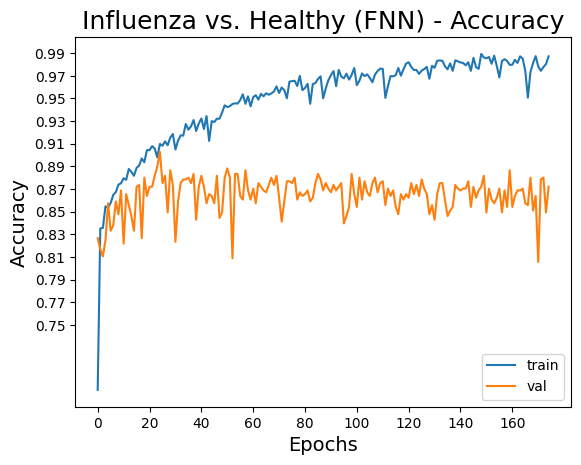

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Influenza vs. Healthy (FNN) - Accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.75, 1.0, 0.02))
plt.xticks(np.arange(0, 170, 20.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

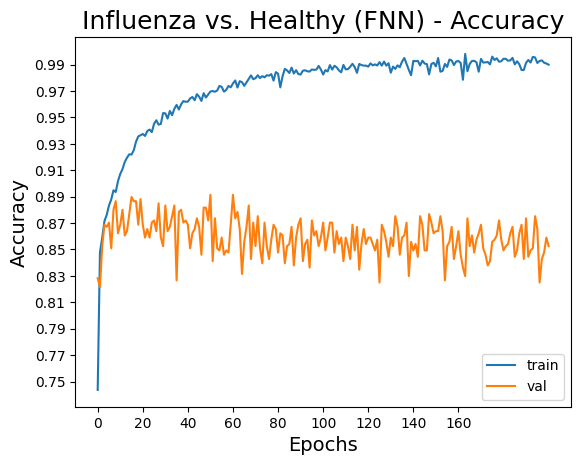

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Influenza vs. Healthy (FNN) - Accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.75, 1.0, 0.02))
plt.xticks(np.arange(0, 170, 20.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 3 Testing

In [30]:
with open('influenza_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [31]:
model.save("influenza_model.h5")

In [31]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 7ms/step - loss: 0.2804 - accuracy: 0.9028


[0.28042253851890564, 0.9027552604675293]

In [32]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 8ms/step - loss: 0.2506 - accuracy: 0.9028


[0.2505754828453064, 0.9027552604675293]

In [13]:
model = tf.keras.models.load_model("influenza_model.h5")

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-02-02 21:26:09.686638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-02 21:26:09.686789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
y_pred = []
y_true = y_test

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 15ms/step


2023-02-02 21:26:30.397512: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-02 21:26:30.454618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([

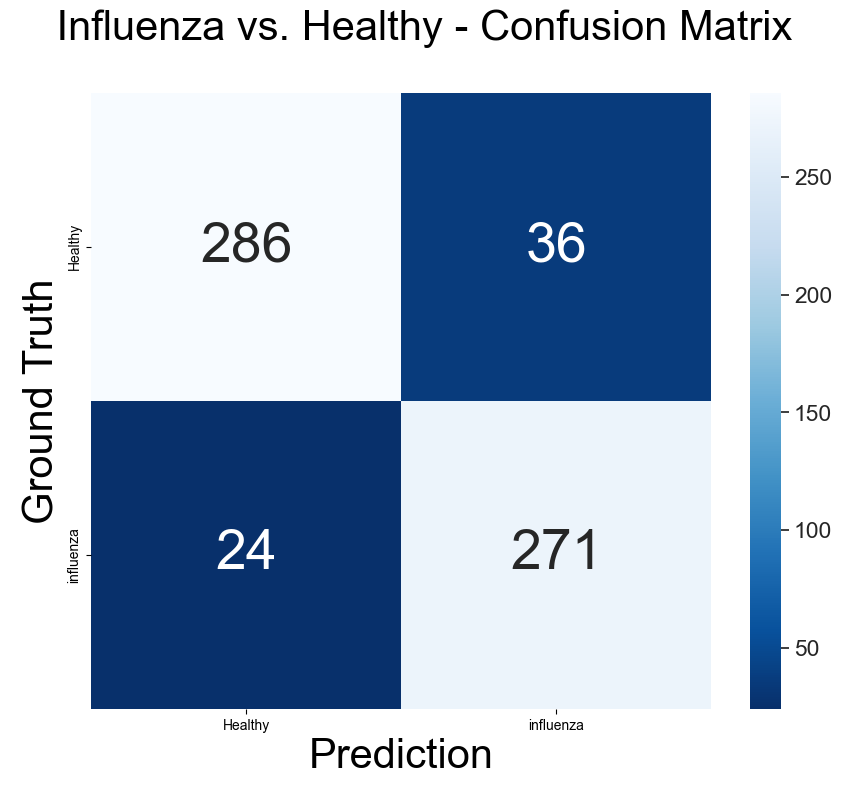

tf.Tensor(
[[286  36]
 [ 24 271]], shape=(2, 2), dtype=int32)


In [17]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
plt.title('    Influenza vs. Healthy - Confusion Matrix\n', fontsize=30)
sns.set(font_scale=1.5)

cmap = sns.color_palette("Blues_r", as_cmap=True)

sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "influenza"],
            yticklabels=["Healthy", "influenza"],
            annot=True, fmt='g', annot_kws={"size":40}, cmap=cmap)
plt.xlabel('Prediction', fontsize=30)
plt.ylabel('Ground Truth', fontsize=30)
plt.show()

print(confusion_mtx)

In [18]:
print(sklearn.metrics.classification_report(correct_labels, predicted_labels, digits=4))

              precision    recall  f1-score   support

           0     0.9226    0.8882    0.9051       322
           1     0.8827    0.9186    0.9003       295

    accuracy                         0.9028       617
   macro avg     0.9027    0.9034    0.9027       617
weighted avg     0.9035    0.9028    0.9028       617



In [36]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

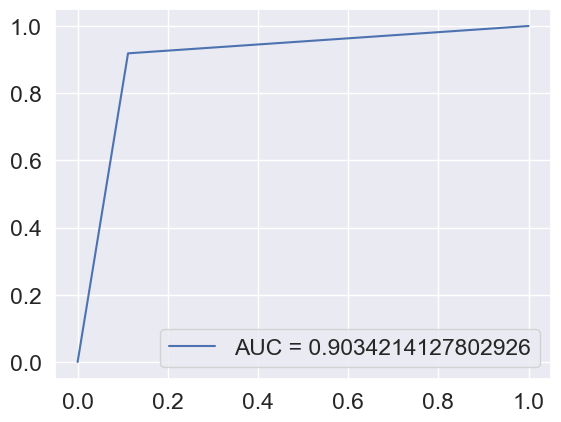

In [37]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()